## VU Machine Learning - TU Wien WS2018

### Dzenan Hamzic BSc, TU Wien

#### Data : ISTANBUL STOCK EXCHANGE Data Set 
https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE

In [9]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
class Performance:
    @staticmethod
    def get_perf(y, y_pred):
        ''' This method outputs several performance metrics for classification. '''

        # ‘explained_variance’
        explained_variance = metrics.explained_variance_score(y_true = y, y_pred = y_pred)

        # R2
        r2 = metrics.r2_score(y_true = y, y_pred = y_pred)

        # ‘neg_mean_absolute_error’
        mean_abs_err = metrics.mean_absolute_error(y_true = y, y_pred = y_pred)
        
        # ‘neg_mean_squared_error’
        mean_sq_err = metrics.mean_squared_error(y_true = y, y_pred = y_pred)
        
        return {'expl_variance': np.round(explained_variance, 6), 'R2': np.round(r2, 6),
                'mean_abs_err': np.round(mean_abs_err,6), 'mean_sq_err': np.round(mean_sq_err,6)}
   

''' Run tests with default algorithm settings '''
def run_tests(test_size, setting, X_train, X_test, y_train, y_test, log = False):
    rstate = 1234
    # algorithms
    algo_names = [
                  "BayesianRidge-Score",
                  "LinearRegression-NonNorm",
                  "LinearRegression-Norm-NoInterc",
                  "DecisionTreeRegressor-",
                  "Ridge",
                  "Ridge-Alpha001",
                  "KNRegressor-distanceN5",
                  "KNRegressor-distanceN50",
                 "KNRegressor-uniformN5"]
    
    algo_list = [BayesianRidge(compute_score=True),
                 LinearRegression(normalize=False),
                 LinearRegression(normalize=True, fit_intercept=False),
                tree.DecisionTreeRegressor(),
                linear_model.Ridge(),
                 linear_model.Ridge(alpha=.001),
                neighbors.KNeighborsRegressor(5, weights="distance"),
                neighbors.KNeighborsRegressor(50, weights="distance"),
                neighbors.KNeighborsRegressor(5, weights="uniform")]
    
    assert len(algo_names) == len(algo_list)
    
    # save prediction values
    predictionDf = pd.DataFrame()
    predictionDf["actual"] = y_test.cumsum()
    
    performanceDf = pd.DataFrame()
    for algo,name in zip(algo_list, algo_names):
        if log: print(algo,setting)
        algo_instance = algo

        t0=time.time()
        if log: print(name,"...fit")
        algo.fit(X_train, y_train)
        fit_time = round(time.time()-t0, 3)

        ## And score it on your testing data.
        if log: print(name,"...score")
        score = algo.score(X_test, y_test)

        ## prediction quality measures
        t0=time.time()
        if log: print(name,"...predict")
        y_predict = algo.predict(X_test)
        pred_time = round(time.time()-t0, 3)
        
        if log: 
            print(name,"...performance")
            print(Performance.get_perf(y_test, y_predict))
            
        predictionDf[name] = y_predict.cumsum()    
            
        pp = Performance.get_perf(y_test, y_predict)
        pp["Algorithm"] = name
        pp["Setting"] = setting
        pp["fit_time"] = fit_time
        pp["pred_time"] = pred_time
        pp["score"] = score
        pp["testSize"] = test_size
        pp["Xsize"] = str(X_train.shape)
        
        pd2 = pd.DataFrame(pp, index=[0])
        performanceDf = pd.concat([performanceDf ,pd2])
        performanceDf.sort_values(by=['R2'], ascending=False, inplace=True)
        
        
    return [performanceDf, predictionDf]
                  

In [3]:
df = pd.read_excel('/home/xxx/MScBI/S4/ML/exer2/data_akbilgic.xlsx' , header=None)
# make new header
df.drop(df.index[0], axis=0, inplace=True)
df.columns = df.iloc[0]
df.drop(df.index[0], axis=0, inplace=True)

## convert date object to date
df["date"] = df["date"].astype('datetime64[ns]')
df.head()

1,date,ISE,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
2,2009-01-05,0.0357537,0.0383762,-0.00467931,0.00219342,0.00389438,0,0.0311902,0.012698,0.0285245
3,2009-01-06,0.0254259,0.0318127,0.00778674,0.00845534,0.0128656,0.00416245,0.0189196,0.0113407,0.00877264
4,2009-01-07,-0.0288617,-0.026353,-0.0304691,-0.0178331,-0.0287346,0.0172929,-0.0358986,-0.0170728,-0.0200154
5,2009-01-08,-0.0622081,-0.0847159,0.00339136,-0.0117263,-0.000465999,-0.0400613,0.0282832,-0.00556096,-0.0194238
6,2009-01-09,0.00985991,0.00965811,-0.0215332,-0.0198728,-0.0127097,-0.0044735,-0.00976388,-0.0109886,-0.00780221


In [31]:
df.shape

(536, 10)

In [4]:
## check missing values

In [5]:
df.isnull().sum()

1
date       0
ISE        0
ISE        0
SP         0
DAX        0
FTSE       0
NIKKEI     0
BOVESPA    0
EU         0
EM         0
dtype: int64

In [6]:
df.dtypes

1
date       datetime64[ns]
ISE                object
ISE                object
SP                 object
DAX                object
FTSE               object
NIKKEI             object
BOVESPA            object
EU                 object
EM                 object
dtype: object

In [7]:
# remove ISE column in turkish currency 
ISE = df.iloc[:, 2]
newdf = pd.concat([ISE,df[["SP","DAX","FTSE","NIKKEI","BOVESPA","EU","EM"]]], axis=1)
newdf.head()

,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
2,0.0383762,-0.00467931,0.00219342,0.00389438,0,0.0311902,0.012698,0.0285245
3,0.0318127,0.00778674,0.00845534,0.0128656,0.00416245,0.0189196,0.0113407,0.00877264
4,-0.026353,-0.0304691,-0.0178331,-0.0287346,0.0172929,-0.0358986,-0.0170728,-0.0200154
5,-0.0847159,0.00339136,-0.0117263,-0.000465999,-0.0400613,0.0282832,-0.00556096,-0.0194238
6,0.00965811,-0.0215332,-0.0198728,-0.0127097,-0.0044735,-0.00976388,-0.0109886,-0.00780221


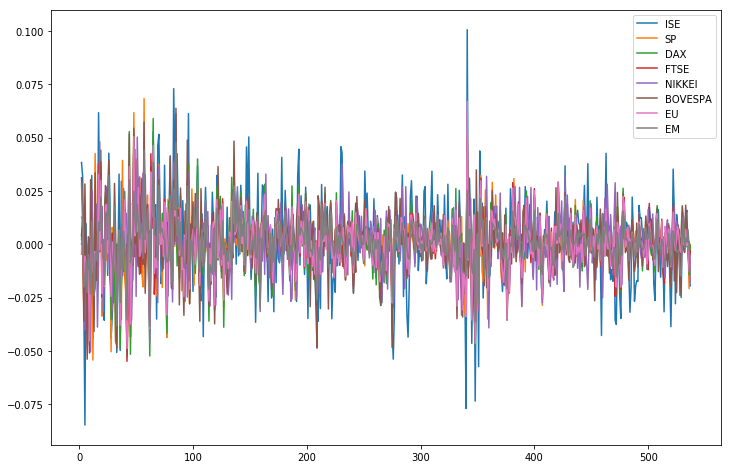

In [10]:
newdf.plot()

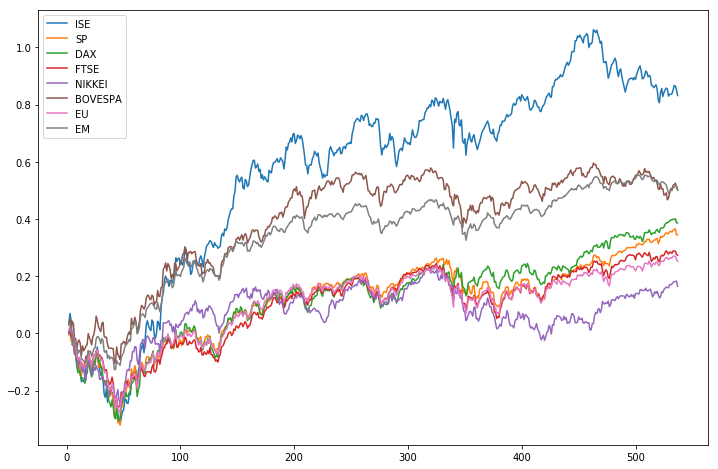

In [11]:
newdf.cumsum().plot()

### prepare X and y

For the purpose of preserving time-series effect we have decided not to shuffle data
and test regression methods on ordered test set.

In [12]:
## use ordered = True to preserve time-series effect
### train and test split
ordered = True

y = newdf["ISE"]#.iloc[:, 2]#df[[df.columns[2]]]
X = newdf[["SP","DAX","FTSE","NIKKEI","BOVESPA","EU","EM"]]

y = pd.to_numeric(y)
X = X.apply(pd.to_numeric)

#if not ordered:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1607)
    
if ordered:
    n = X.shape[0]
    train_size = 0.6
    tsize = int(n * train_size)

    X_train, X_test, y_train, y_test = X.iloc[:tsize], X.iloc[tsize:], y.iloc[:tsize], y.iloc[tsize:]
    
print(X.shape)

(536, 7)


In [13]:
X_train.dtypes

SP         float64
DAX        float64
FTSE       float64
NIKKEI     float64
BOVESPA    float64
EU         float64
EM         float64
dtype: object

In [14]:
#plt.plot(y_train + y_test)
#plt.plot([None for i in y_train] + [x for x in y_test])

## Setting 1:
 - test data is 33% of the complete dataframe
 - X has dimension of (321, 7)

In [15]:
resultdfs = run_tests(0.33, "raw_data", X_train, X_test, y_train, y_test, False)
resultdfs[0]

,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,mean_sq_err,pred_time,score,testSize
0,LinearRegression-Norm-NoInterc,0.605218,raw_data,"(321, 7)",0.605292,0.001,0.009300,0.000146,0.000,0.605218,0.33
0,BayesianRidge-Score,0.603249,raw_data,"(321, 7)",0.607892,0.018,0.009237,0.000146,0.000,0.603249,0.33
0,Ridge-Alpha001,0.603114,raw_data,"(321, 7)",0.607814,0.001,0.009230,0.000146,0.000,0.603114,0.33
0,LinearRegression-NonNorm,0.599860,raw_data,"(321, 7)",0.604043,0.002,0.009322,0.000148,0.000,0.599860,0.33
0,KNRegressor-distanceN20,0.444369,raw_data,"(321, 7)",0.462392,0.000,0.010076,0.000205,0.003,0.444369,0.33
0,KNRegressor-distanceN5,0.418153,raw_data,"(321, 7)",0.425880,0.001,0.010826,0.000215,0.002,0.418153,0.33
0,KNRegressor-uniformN5,0.417442,raw_data,"(321, 7)",0.425521,0.000,0.010771,0.000215,0.001,0.417442,0.33
0,Ridge,0.187342,raw_data,"(321, 7)",0.200442,0.002,0.012420,0.000300,0.000,0.187342,0.33
0,DecisionTreeRegressor-,-0.135130,raw_data,"(321, 7)",-0.127050,0.004,0.015721,0.000419,0.000,-0.135130,0.33


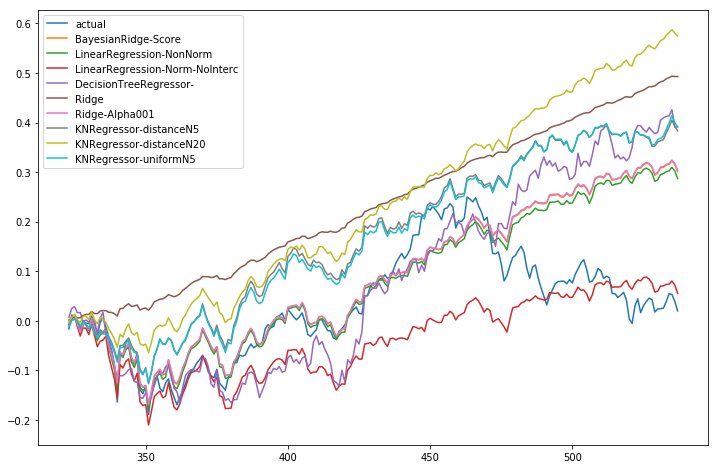

In [16]:
if ordered:
    ax1 = resultdfs[1].plot()

### Setting 1:  CV
 - Cross validation with different parameter settings

In [17]:
param_grid_linear_reg = { 
    'fit_intercept': [True, False],
    'normalize' : [True, False]
}
lr = LinearRegression()
CV_dtc = GridSearchCV(estimator=lr, param_grid=param_grid_linear_reg, cv = 5, n_jobs=-1)
CV_dtc.fit(X, y)
lr_best_params = CV_dtc.best_params_
print("Linear Reg - best params: ",lr_best_params)

Linear Reg - best params:  {'fit_intercept': False, 'normalize': True}


In [18]:
param_grid_bayesian_ridge = {
    'fit_intercept': [True, False],
    'n_iter' : [100,400,800],
    'alpha_1' : [0.1, 1.e-4, 1.e-8, 1.e-10, 1.e-20],
    'alpha_2' : [0.1, 1.e-4, 1.e-8, 1.e-10, 1.e-20],
    'lambda_1' : [0.1, 1.e-4, 1.e-8, 1.e-10, 1.e-20],
    'lambda_2' : [0.1, 1.e-4, 1.e-8, 1.e-10, 1.e-20],
    'compute_score' : [True, False]
}

mod = BayesianRidge()
CV_dtc = GridSearchCV(estimator=mod, param_grid=param_grid_bayesian_ridge, cv = 5, n_jobs=-1)
CV_dtc.fit(X, y)
rr_best_params = CV_dtc.best_params_
print("Bayesian Ridge - best params: ",rr_best_params)



Bayesian Ridge - best params:  {'lambda_1': 0.1, 'alpha_2': 0.0001, 'compute_score': True, 'fit_intercept': False, 'alpha_1': 1e-20, 'n_iter': 100, 'lambda_2': 0.0001}


### Setting 1:  CV - results for best performing algorithms

In [19]:
# bayesian regression
bregr = BayesianRidge(**rr_best_params)
bregr.fit(X_train, y_train)

# linear regression
regr = linear_model.LinearRegression(**lr_best_params)
regr.fit(X_train, y_train)

#print("R^2: ", regr.score(X_train, y_train))
#print("bregr R^2: ", bregr.score(X_train, y_train))

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred2 = bregr.predict(X_test)


print('LR Coefficients: \n', regr.coef_)
print("LR Mean squared error: %.5f"% metrics.mean_squared_error(y_test, y_pred))
print('LR Variance score: %.2f' % metrics.r2_score(y_test, y_pred))


print('BR Coefficients: \n', bregr.coef_)
print("BR Mean squared error: %.5f"% metrics.mean_squared_error(y_test, y_pred2))
print('BR Variance score: %.2f' % metrics.r2_score(y_test, y_pred2))

LR Coefficients: 
 [ 0.14614575 -0.11085546 -0.51323426  0.07605328 -0.28300664  1.17724122
  0.98371403]
LR Mean squared error: 0.00015
LR Variance score: 0.61
BR Coefficients: 
 [ 0.12324626  0.01256906 -0.27384847  0.10124517 -0.24402252  0.81564912
  0.9239995 ]
BR Mean squared error: 0.00014
BR Variance score: 0.61


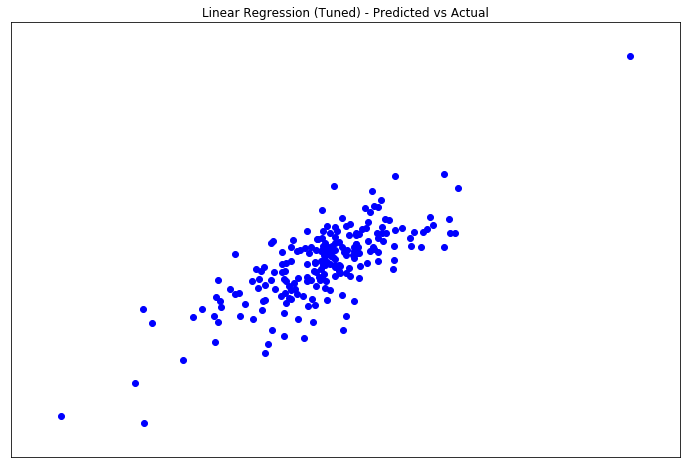

In [20]:
plt.scatter(y_pred, y_test,  color='blue')
#plt.plot(X_test, , color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())
plt.title("Linear Regression (Tuned) - Predicted vs Actual")
plt.show()

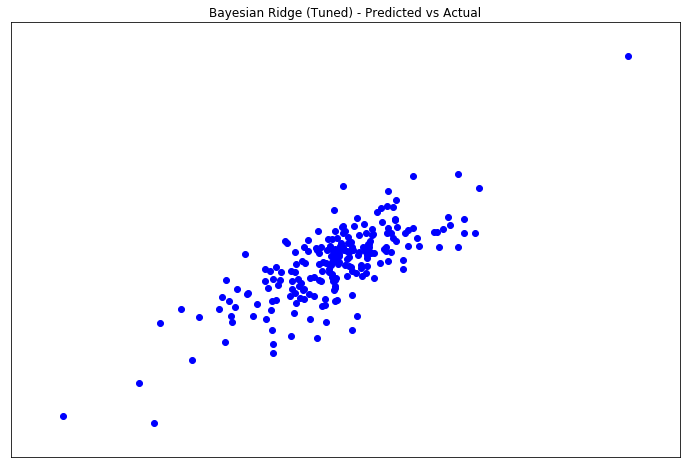

In [21]:
plt.scatter(y_pred2, y_test,  color='blue')
#plt.plot(X_test, , color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())
plt.title("Bayesian Ridge (Tuned) - Predicted vs Actual")
plt.show()

## Setting 2: regression tests with squared polynomial transformed data
 - test data is 33% of the complete dataframe
 - X has dimension of (321, 36)

In [22]:
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly2 = poly.fit_transform(X_train)
X_test_poly2 = poly.transform(X_test)

resultdfs = run_tests(0.33, "poly^"+str(degree), X_train_poly2, X_test_poly2, y_train, y_test, False)
resultdfs[0]

,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,mean_sq_err,pred_time,score,testSize
0,Ridge-Alpha001,0.600706,poly^2,"(321, 36)",0.606353,0.001,0.009231,0.000147,0.000,0.600706,0.33
0,BayesianRidge-Score,0.600481,poly^2,"(321, 36)",0.606195,0.018,0.009239,0.000147,0.000,0.600481,0.33
0,LinearRegression-Norm-NoInterc,0.462160,poly^2,"(321, 36)",0.473908,0.009,0.010035,0.000198,0.000,0.462160,0.33
0,KNRegressor-distanceN20,0.444326,poly^2,"(321, 36)",0.462350,0.001,0.010076,0.000205,0.009,0.444326,0.33
0,KNRegressor-distanceN5,0.418149,poly^2,"(321, 36)",0.425876,0.001,0.010826,0.000215,0.006,0.418149,0.33
0,KNRegressor-uniformN5,0.417442,poly^2,"(321, 36)",0.425521,0.001,0.010771,0.000215,0.005,0.417442,0.33
0,LinearRegression-NonNorm,0.372024,poly^2,"(321, 36)",0.393341,0.005,0.010872,0.000232,0.000,0.372024,0.33
0,Ridge,0.187340,poly^2,"(321, 36)",0.200441,0.001,0.012420,0.000300,0.000,0.187340,0.33
0,DecisionTreeRegressor-,-0.096593,poly^2,"(321, 36)",-0.096586,0.014,0.015227,0.000405,0.000,-0.096593,0.33


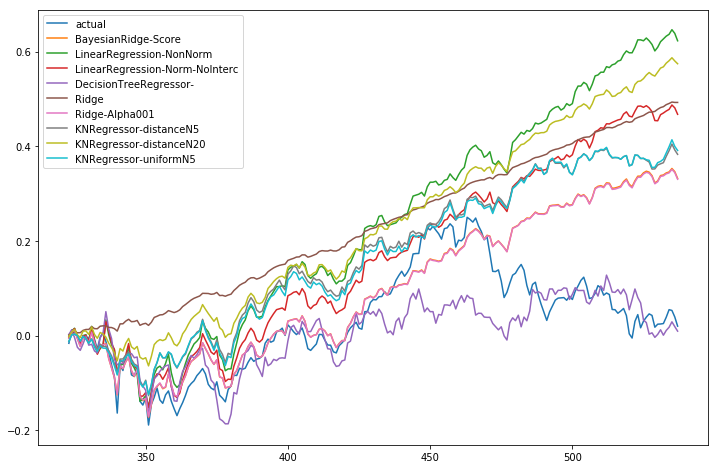

In [23]:
#axes = plt.gca()
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([-1,1])
ax1 = resultdfs[1].plot()
#ax1.set_ylim(-0.1,0.1)

In [24]:
resultdfs[1].head()

,actual,BayesianRidge-Score,LinearRegression-NonNorm,LinearRegression-Norm-NoInterc,DecisionTreeRegressor-,Ridge,Ridge-Alpha001,KNRegressor-distanceN5,KNRegressor-distanceN20,KNRegressor-uniformN5
323,-0.016214,-0.005467,-0.001953,-0.003910,0.002705,0.001422,-0.005457,-0.012281,-0.002255,-0.012304
324,0.011932,0.007273,0.009766,0.008944,0.012077,0.005638,0.007180,0.001505,0.007791,0.001395
325,0.008641,0.012729,0.015625,0.014863,-0.004381,0.008355,0.012614,0.003431,0.013136,0.003239
326,-0.003157,-0.006220,-0.001953,-0.001957,-0.024774,0.005967,-0.006321,-0.000016,0.001337,-0.000140
327,-0.017369,-0.022790,-0.017578,-0.018042,-0.031111,0.006248,-0.022738,-0.011434,-0.003809,-0.011854


In [25]:
reg = linear_model.RidgeCV(alphas=[0.001, 0.0001, 0.01, 0.1,1.0, 10.0], cv=3)
reg.fit(X_train, y_train)
reg.alpha_

0.001

## Setting 3: regression tests with Principal Components
 - test data is 33% of the complete dataframe
 - X has dimension of (321, 1)

In [26]:
from sklearn.decomposition import PCA
# scale
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_pca_scaled = scaler.transform(X_train)
X_test_pca_scaled = scaler.transform(X_test)

pca = PCA(n_components=1)  

# project to PCs
X_train_pca = pca.fit_transform(X_train_pca_scaled)  
X_test_pca = pca.transform(X_test_pca_scaled) 

resultdfs = run_tests(0.33, "PCA2", X_train_pca, X_test_pca, y_train, y_test, False)
resultdfs[0]

,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,mean_sq_err,pred_time,score,testSize
0,LinearRegression-Norm-NoInterc,0.549215,PCA2,"(321, 1)",0.552273,0.001,0.010004,0.000166,0.000,0.549215,0.33
0,LinearRegression-NonNorm,0.546438,PCA2,"(321, 1)",0.552273,0.001,0.009908,0.000167,0.000,0.546438,0.33
0,Ridge-Alpha001,0.546438,PCA2,"(321, 1)",0.552273,0.001,0.009908,0.000167,0.000,0.546438,0.33
0,Ridge,0.546321,PCA2,"(321, 1)",0.552161,0.002,0.009908,0.000167,0.000,0.546321,0.33
0,BayesianRidge-Score,0.545802,PCA2,"(321, 1)",0.551664,0.001,0.009907,0.000168,0.000,0.545802,0.33
0,KNRegressor-distanceN20,0.366586,PCA2,"(321, 1)",0.371572,0.000,0.011945,0.000234,0.001,0.366586,0.33
0,KNRegressor-uniformN5,0.320174,PCA2,"(321, 1)",0.325131,0.000,0.012455,0.000251,0.000,0.320174,0.33
0,KNRegressor-distanceN5,0.218839,PCA2,"(321, 1)",0.221200,0.000,0.013564,0.000288,0.000,0.218839,0.33
0,DecisionTreeRegressor-,-0.183270,PCA2,"(321, 1)",-0.180821,0.001,0.016692,0.000437,0.000,-0.183270,0.33


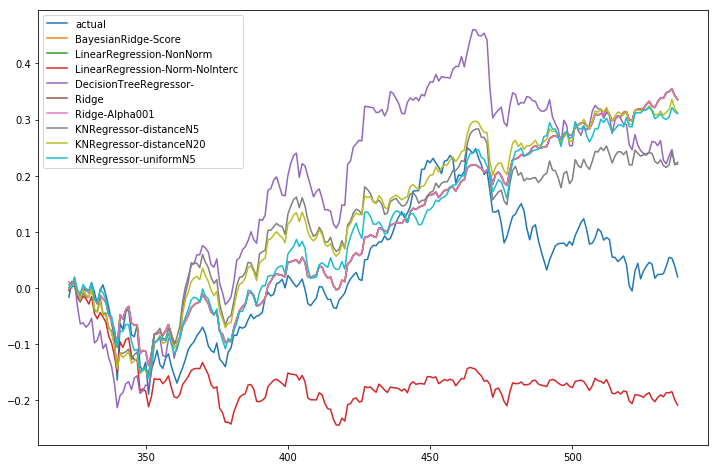

In [27]:
resultdfs[1].plot()

## Auto-sklearn Regression

In [30]:
import autosklearn.regression

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import warnings; warnings.simplefilter('ignore')

import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=4000,
    per_run_time_limit=40,
    #tmp_folder='/tmp/autosklearn_regression_example_tmp',
    #output_folder='/tmp/autosklearn_regression_example_out'
)
print(".... FIT.....")
automl.fit(X_train, y_train)
print(".... FIT... END ...")

print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

.... FIT.....
[WARNING] [2019-01-06 14:33:59,385:AutoMLSMBO(1)::d61b402c8b3b8e49fdfb9b0f56373967] Could not find meta-data directory /home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-01-06 14:33:59,400:EnsembleBuilder(1):d61b402c8b3b8e49fdfb9b0f56373967] No models better than random - using Dummy Score!
[WARNING] [2019-01-06 14:33:59,409:EnsembleBuilder(1):d61b402c8b3b8e49fdfb9b0f56373967] No models better than random - using Dummy Score!
[14:34:45] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:34:45] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:34:45] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:34:45] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:34:45] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:34:45] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:34:45] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, w

[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:33] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:34] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:34] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:34] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:34] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:37:34] /workspac

[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:40:11] /workspac

[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:47:50] /workspac

[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspac

[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[14:50:49] /workspac

[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:02:14] /workspac

[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:53] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:03:54] /workspac

[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:57] /workspac

[15:05:58] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:58] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:58] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:58] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:58] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:58] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:05:59] /workspac

[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1.00787
[15:06:01] /

[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:10:59] /workspac

[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = -nan
[15:11:01] /workspace/src/gbm/gbtree.cc:492: drop 1

[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:11:59] /workspac

[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:12:01] /workspac

[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:10] /workspac

[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:13:11] /workspac

[15:17:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:07] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:07] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:07] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:17:07] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:18:05] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:18:05] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:18:05] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:18:05] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:18:05] /workspac

[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:14] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:21:15] /workspac

[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:00] /workspac

[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:22:01] /workspac

[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:23:02] /workspac

[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:39] /workspac

[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspac

[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspac

[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:27:41] /workspac

[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:31:29] /workspac

[15:34:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:40] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspac

[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:34:41] /workspac

[15:34:42] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:34:42] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:34:42] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:34:42] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[15:37:15] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:15] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:15] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:37:16] /workspac

[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[15:39:06] /workspac